<a href="https://colab.research.google.com/github/Dhivyagkrishnan/Enhanced_Adaptive_Delta-modulation/blob/main/EADM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install librosa soundfile matplotlib numpy


In [ ]:
 import soundfile as sf

# Load the FLAC file from the correct path
data, samplerate = sf.read('/content/61-70968-0001.flac')  # Note the leading slash

# Save it as a WAV file
sf.write('/content/converted_audio.wav', data, samplerate)

print("Conversion complete: FLAC → WAV")



Conversion complete: FLAC → WAV


In [ ]:
import soundfile as sf

data, sr = sf.read('/content/converted_audio.wav')

if len(data.shape) == 1:
    print("Audio is mono")
else:
    print(f"Audio is stereo with {data.shape[1]} channels")


Audio is mono


In [ ]:
import soundfile as sf
import numpy as np

# Load the WAV file
data, samplerate = sf.read('/content/converted_audio.wav')

# Normalize the audio to [-1, 1]
normalized_data = data / np.max(np.abs(data))

# Save the normalized audio (optional, for verification)
sf.write('/content/normalized_audio.wav', normalized_data, samplerate)

print("Audio normalized and saved as normalized_audio.wav")



Audio normalized and saved as normalized_audio.wav


In [ ]:
import soundfile as sf
import librosa
import numpy as np

# Load audio
data, samplerate = sf.read('/content/converted_audio.wav')

# Duration in seconds
duration = len(data) / samplerate

# Channels
channels = 1 if len(data.shape) == 1 else data.shape[1]

# Print basic info
print(f"Sampling Rate      : {samplerate} Hz")
print(f"Duration           : {duration:.2f} seconds")
print(f"Number of Channels : {channels}")
print(f"Total Samples      : {len(data)}")

# Load with librosa for spectral analysis
y, sr = librosa.load('/content/converted_audio.wav', sr=None)

# Compute frequency range using FFT
fft = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(fft), 1/sr)
magnitude = np.abs(fft)

# Consider only positive frequencies
pos_freqs = frequencies[:len(frequencies)//2]
pos_magnitudes = magnitude[:len(magnitude)//2]

# Frequency range estimation (non-zero magnitude threshold)
threshold = 0.01 * np.max(pos_magnitudes)
valid_freqs = pos_freqs[pos_magnitudes > threshold]

freq_min = valid_freqs.min() if valid_freqs.size > 0 else 0
freq_max = valid_freqs.max() if valid_freqs.size > 0 else sr / 2

print(f"Estimated Frequency Range: {freq_min:.2f} Hz – {freq_max:.2f} Hz")


Sampling Rate      : 16000 Hz
Duration           : 3.61 seconds
Number of Channels : 1
Total Samples      : 57760
Estimated Frequency Range: 0.00 Hz – 7191.14 Hz


In [ ]:
from IPython.display import Audio

# Play your WAV file
Audio('/content/converted_audio.wav')


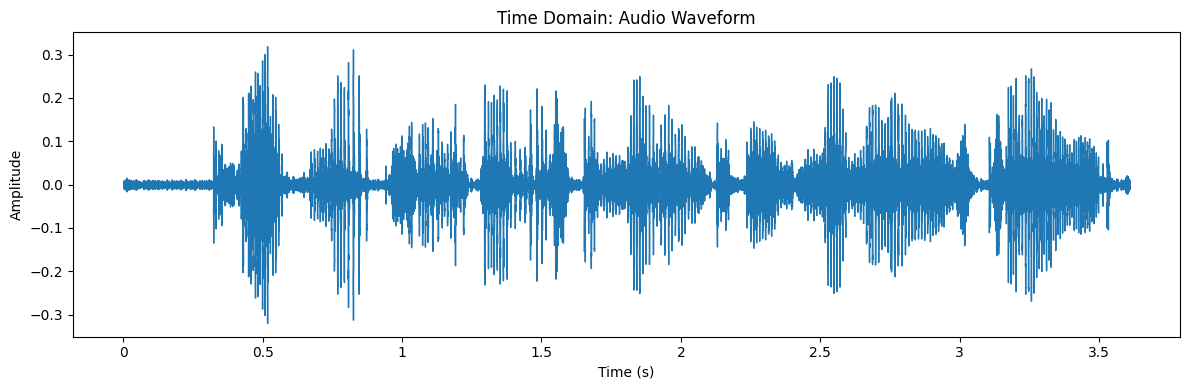

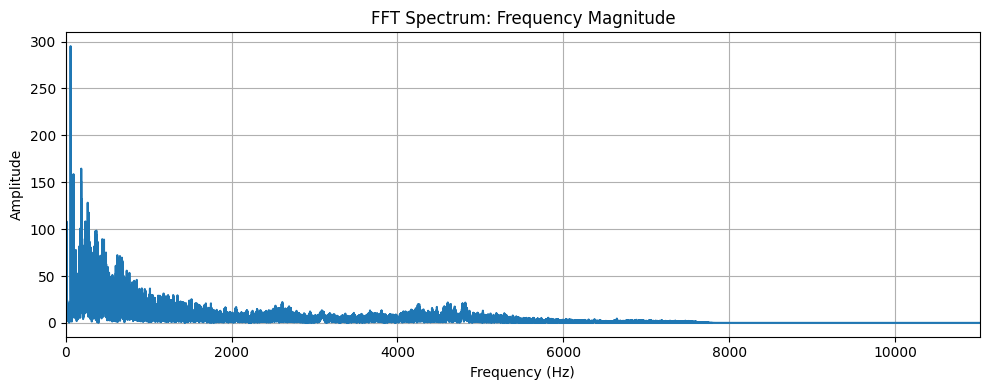

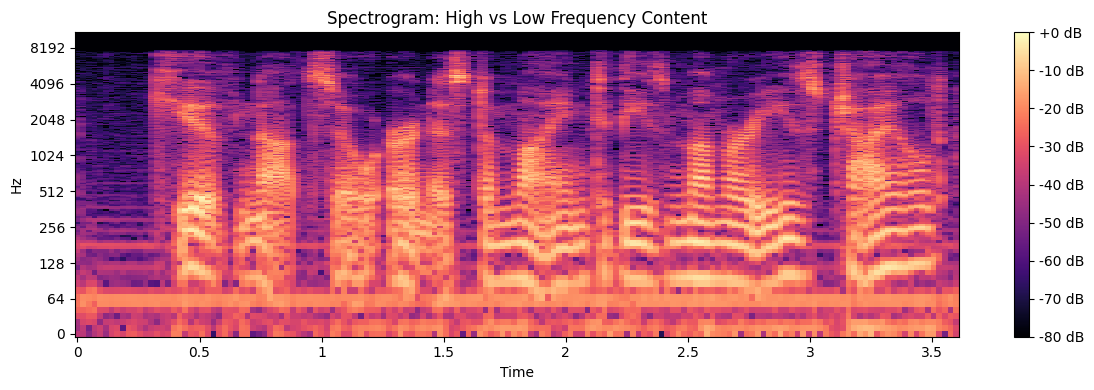

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
y, sr = librosa.load('/content/converted_audio.wav')
# === 1 Time-Domain Waveform ===
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Time Domain: Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()
# === 2️⃣ FFT Spectrum (global frequency content) ===
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(Y), 1/sr)

# Keep only the positive frequencies
idx = np.where(freqs >= 0)
freqs = freqs[idx]
Y = np.abs(Y[idx])

plt.figure(figsize=(10, 4))
plt.plot(freqs, Y)
plt.title("FFT Spectrum: Frequency Magnitude")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim([0, sr//2])  # up to Nyquist frequency
plt.tight_layout()
plt.show()
# Load audio
y, sr = librosa.load('/content/converted_audio.wav')

# === 1️⃣ Spectrogram (time vs frequency vs energy) ===
D = np.abs(librosa.stft(y))
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')  # log scale helps separate low/high better
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram: High vs Low Frequency Content")
plt.tight_layout()
plt.show()





LINEAR DELTA MODULATION


🔻 Worst Step Size (Minimal HF Retention): 0.0100
📉 High-frequency Retention: 0.01%


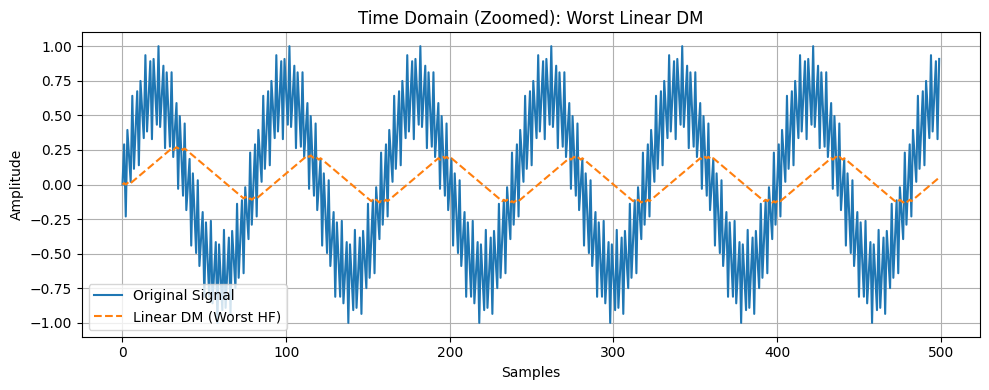

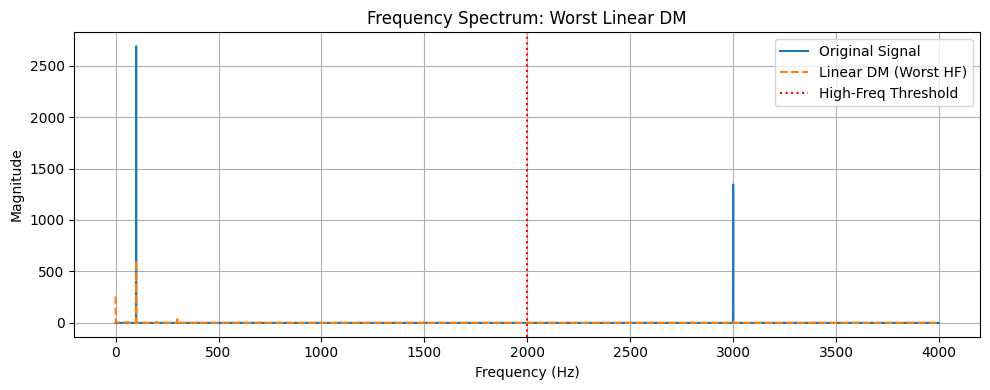

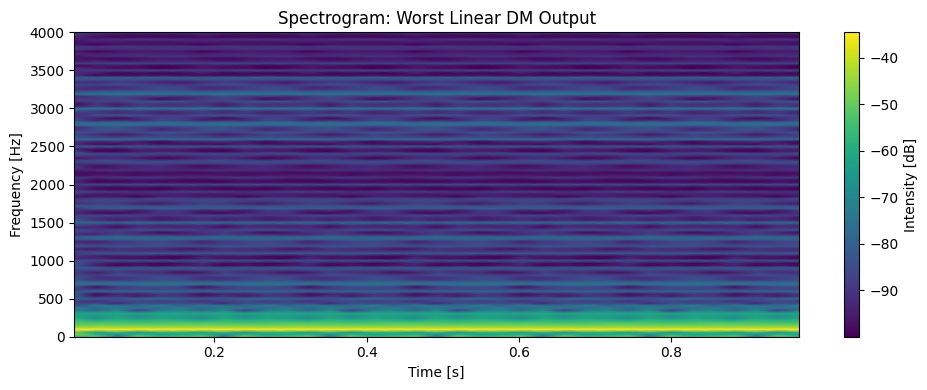

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram

# --- Signal setup (synthetic signal)
fs = 8000  # Hz
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 100 * t) + 0.5 * np.sin(2 * np.pi * 3000 * t)

# ✅ Normalize original signal only
signal = signal / np.max(np.abs(signal))

# --- Linear Delta Modulation
def linear_delta_modulation_encode(signal, step_size):
    predicted_signal = np.zeros_like(signal)
    predicted_signal[0] = signal[0]
    for i in range(1, len(signal)):
        if signal[i] > predicted_signal[i-1]:
            predicted_signal[i] = predicted_signal[i-1] + step_size
        else:
            predicted_signal[i] = predicted_signal[i-1] - step_size
    return predicted_signal

# --- Frequency domain utility (accurate retention)
def compute_high_freq_retention(original, decoded, fs, threshold=2000):
    N = len(original)
    freqs = fftfreq(N, 1 / fs)[:N // 2]
    orig_fft = np.abs(fft(original))[:N // 2]
    dec_fft = np.abs(fft(decoded))[:N // 2]

    hf_indices = np.where((freqs > threshold) & (freqs < fs / 2))
    orig_energy = np.sum(orig_fft[hf_indices] ** 2)
    dec_energy = np.sum(dec_fft[hf_indices] ** 2)
    return dec_energy / orig_energy if orig_energy != 0 else 0

# --- Optimize step size for minimal high-frequency retention
step_sizes = np.linspace(0.01, 1.0, 100)
worst_retention = float('inf')
worst_step_size = 0
worst_decoded = None

for step in step_sizes:
    decoded = linear_delta_modulation_encode(signal, step)
    retention = compute_high_freq_retention(signal, decoded, fs)
    if retention < worst_retention:
        worst_retention = retention
        worst_step_size = step
        worst_decoded = decoded

print(f"🔻 Worst Step Size (Minimal HF Retention): {worst_step_size:.4f}")
print(f"📉 High-frequency Retention: {worst_retention * 100:.2f}%")

# --- Plot results using worst step size
# Time Domain
plt.figure(figsize=(10, 4))
plt.plot(signal[:500], label="Original Signal")
plt.plot(worst_decoded[:500], label="Linear DM (Worst HF)", linestyle='--')
plt.title("Time Domain (Zoomed): Worst Linear DM")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Frequency Domain
N = len(signal)
freqs = fftfreq(N, 1 / fs)[:N // 2]
original_fft = np.abs(fft(signal))[:N // 2]
decoded_fft = np.abs(fft(worst_decoded))[:N // 2]

plt.figure(figsize=(10, 4))
plt.plot(freqs, original_fft, label="Original Signal")
plt.plot(freqs, decoded_fft, label="Linear DM (Worst HF)", linestyle='--')
plt.axvline(2000, color='r', linestyle=':', label='High-Freq Threshold')
plt.title("Frequency Spectrum: Worst Linear DM")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Spectrogram
f, t_spec, Sxx = spectrogram(worst_decoded, fs)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
plt.title("Spectrogram: Worst Linear DM Output")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()
plt.show()


LOGARTHMIC ADAPTIVE DELTA MODULATION


✅ Optimal Base Delta: 0.0619
📈 Best High-frequency Retention (Log-ADM): 65.49%


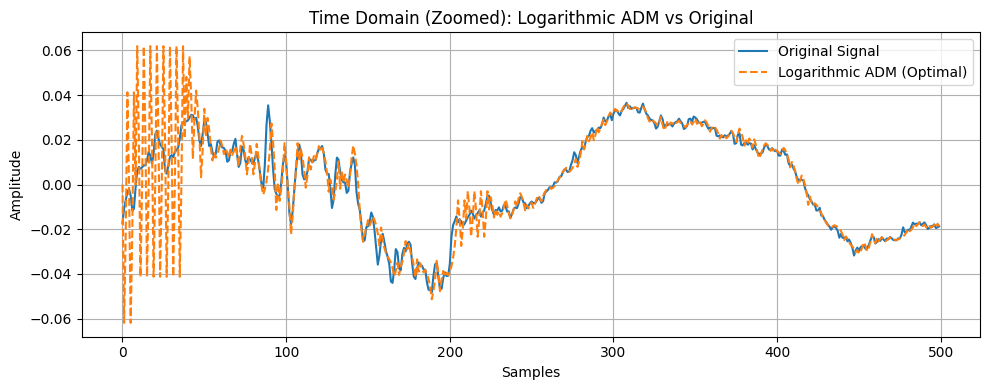

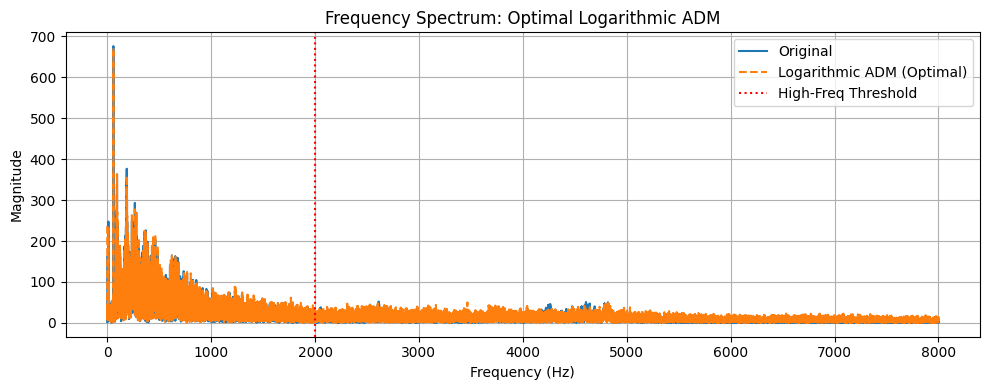

Text(0, 0.5, 'Frequency [Hz]')

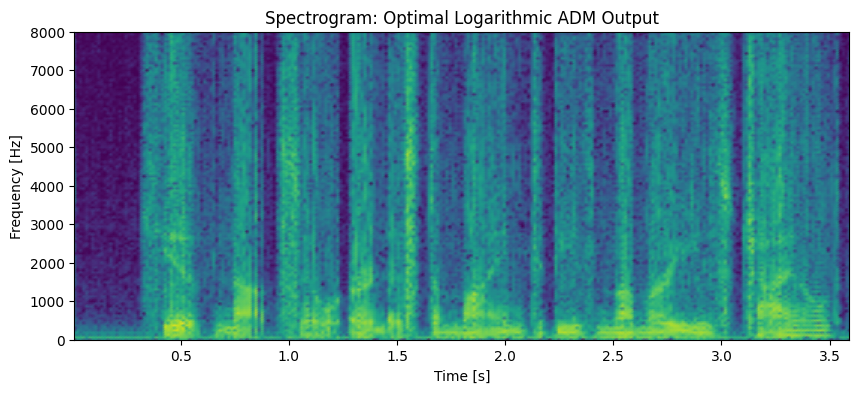

In [ ]:
 import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram

# --- Load and Normalize Speech Signal
fs, signal = wavfile.read('converted_audio.wav')
signal = signal.astype(np.float32)
signal = signal / np.max(np.abs(signal))  # Normalize to [-1, 1]

# --- Logarithmic ADM Function
def log_adm(signal, base_delta=0.01, scale=1.5, max_delta=1.0, min_delta=1e-5):
    encoded = []
    reconstructed = [0]
    delta = base_delta
    for i in range(1, len(signal)):
        error = signal[i] - reconstructed[-1]
        if error > 0:
            encoded.append(1)
            reconstructed.append(reconstructed[-1] + delta)
        else:
            encoded.append(0)
            reconstructed.append(reconstructed[-1] - delta)
        delta *= scale if abs(error) > delta else (1 / scale)
        delta = np.clip(delta, min_delta, max_delta)
    return np.array(encoded), np.array(reconstructed)

# --- Frequency Retention Utility
def compute_retention(original, reconstructed, fs, threshold=2000):
    N = len(original)
    freqs = fftfreq(N, 1 / fs)[:N // 2]
    orig_fft = np.abs(fft(original))[:N // 2]
    rec_fft = np.abs(fft(reconstructed))[:N // 2]
    hf_indices = np.where((freqs > threshold) & (freqs < fs / 2))
    orig_energy = orig_fft[hf_indices] ** 2
    rec_energy = rec_fft[hf_indices] ** 2
    retained_energy = np.sum(np.minimum(orig_energy, rec_energy))
    total_energy = np.sum(orig_energy)
    return retained_energy / total_energy if total_energy != 0 else 0, freqs, orig_fft, rec_fft

# --- Optimize base_delta
base_deltas = np.linspace(0.001, 0.2, 50)
best_retention = 0
best_base_delta = 0
best_decoded = None

for delta in base_deltas:
    _, decoded = log_adm(signal, base_delta=delta)
    retention, _, _, _ = compute_retention(signal, decoded, fs)
    if retention > best_retention:
        best_retention = retention
        best_base_delta = delta
        best_decoded = decoded

print(f"✅ Optimal Base Delta: {best_base_delta:.4f}")
print(f"📈 Best High-frequency Retention (Log-ADM): {best_retention * 100:.2f}%")

# --- Plot: Time Domain
plt.figure(figsize=(10, 4))
plt.plot(signal[:500], label="Original Signal")
plt.plot(best_decoded[:500], label="Logarithmic ADM (Optimal)", linestyle='--')
plt.title("Time Domain (Zoomed): Logarithmic ADM vs Original")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot: Frequency Domain
_, freqs, original_fft, log_decoded_fft = compute_retention(signal, best_decoded, fs)

plt.figure(figsize=(10, 4))
plt.plot(freqs, original_fft, label="Original")
plt.plot(freqs, log_decoded_fft, label="Logarithmic ADM (Optimal)", linestyle='--')
plt.axvline(2000, color='r', linestyle=':', label='High-Freq Threshold')
plt.title("Frequency Spectrum: Optimal Logarithmic ADM")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot: Spectrogram
f, t_spec, Sxx = spectrogram(best_decoded, fs)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
plt.title("Spectrogram: Optimal Logarithmic ADM Output")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
